# ANN assisted TPS on capped alanine dipeptide 2
In this notebook you will learn
- how to perform input importance analyses for models with transformed atomistic coordinates, i.e. how to find which are the important ANN inputs and how to relate them to atomistic coordinates
- how to create visualizizations of the transitions colored by gradient

This notebook uses files created in `1_setup_and_TPS.ipynb`, please do this notebook first.

In [1]:
%matplotlib inline

In [2]:
import os
import arcd
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 9, 6  # make the figures a bit bigger
import openpathsampling as paths

Using TensorFlow backend.


In [3]:
# change to the working directory of choice
# same as for the first notebook
wdir = '/homeloc/scratch/hejung/arcd_scratch/ala/'
wdir = None
if wdir is not None:
    os.chdir(wdir)

In [4]:
storage = paths.Storage('ala_HB_TPS.nc', 'a')

In [5]:
# get the sampler, attach the hook and run for 1 step to repopulate the trainset and load the model
sampler = storage.pathsimulators[0]
sampler.restart_at_step(storage.steps[-1], storage=storage)

trainhook = arcd.ops.TrainingHook(None, None, 100)
sampler.attach_hook(trainhook)

sampler.run(1)

Working on Monte Carlo cycle number 1001
Starting simulation...
Working on first step


/opt/conda/envs/arcd_devel/lib/python3.6/site-packages/mdtraj/utils/validation.py:116: TypeCastPerformanceWarning: Casting unitcell_vectors dtype=float64 to <class 'numpy.float32'> 
  TypeCastPerformanceWarning)


DONE! Completed 1001 Monte Carlo cycles.


In [17]:
# lets make a movie
gmovie = arcd.analysis.GradientMovieMaker(trainhook.model, trainhook.model.descriptor_transform, storage.snapshots[-1].topology.mdtraj)

In [20]:
tras = []
for step in storage.steps[-50:]:
    if step.change.canonical.accepted:
        tras.append(step.change.canonical.trials[0].trajectory)

In [21]:
[len(t) for t in tras]

[35, 36, 48, 88, 39, 55, 39, 74]

In [22]:
top = storage.snapshots[-1].topology.mdtraj

In [23]:
ats = top.select('not resname HOH')

In [24]:
ats

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

In [25]:
gmovie.color_by_gradient(tras[0], 'ala_movie.pdb', atom_indices=ats)

## HIPR analysis
We will have a look at the most important inputs and which atoms contribute to them.

In [6]:
hipr = arcd.analysis.HIPRanalysis(trainhook.model, trainhook.trainset)

In [7]:
final_hipr_losses = hipr.do_hipr()

In [8]:
# lets load the model after 100 MCsteps to compare
from arcd.base.rcmodel import RCModel
fname = storage.abspath + '_RCmodel_at_step500.pckl'
state, cls = RCModel.load_state(fname, storage)
state = cls.fix_state(state)
model_at_step100 = cls.set_state(state)

In [9]:
# use the complete trainset for HIPR
# this includes point the ANN has never trained on but makes it comparable to the previous HIPR
hipr_at_step100 = arcd.analysis.HIPRanalysis(model_at_step100, trainhook.trainset)

In [10]:
step100_hipr_losses = hipr_at_step100.do_hipr()

Reference loss:  1.3406338839383274
coordinate:  ('sin', [8, 14, 16, 18])
with associated loss:  1.375872537496683
coordinate:  ('cos', [1, 4, 6, 8])
with associated loss:  1.348464947528058
coordinate:  ('cos', [4, 6, 8, 14])
with associated loss:  1.3468585857501874
coordinate:  [16, 18, 20]
with associated loss:  1.346688742166037
coordinate:  ('cos', [14, 16, 18, 19])
with associated loss:  1.3446988924161776


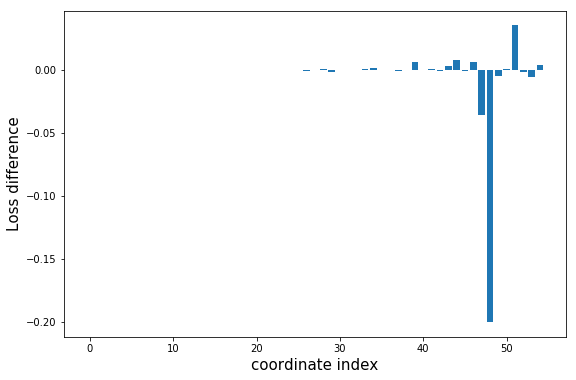

In [11]:
final_loss_diff = final_hipr_losses[:-1] - final_hipr_losses[-1]
step100_loss_diff = step100_hipr_losses[:-1] - step100_hipr_losses[-1]

plt.bar(np.arange(len(final_loss_diff)), final_loss_diff)
plt.xlabel('coordinate index', size=15)
plt.ylabel('Loss difference', size=15)

# get the associated coordinates for the maximally important input
max_idx = np.argsort(final_loss_diff)[::-1]

# this bit below only works for IC only
# figuring out how to get the info for SF CVs is left as an excersise to the reader :)
ic_parms = trainhook.model.descriptor_transform.kwargs['ic_parms']


print('Reference loss: ', final_hipr_losses[-1])
for idx in max_idx[:5]:
    # this little helper function gets you the involved atoms given the input index and the inputparameters to the CV of question
    # there is similar functions for the symmetry functions @ arcd.coords.symmetry.get_involved
    print('coordinate: ', arcd.coords.internal.get_involved(idx, **ic_parms))
    print('with associated loss: ', final_hipr_losses[idx])

Reference loss:  1.2802072195382743
coordinate:  ('sin', [6, 8, 10, 11])
with associated loss:  1.3020052548769592
coordinate:  ('sin', [8, 14, 16, 18])
with associated loss:  1.2961673458377558
coordinate:  ('cos', [14, 16, 18, 19])
with associated loss:  1.2891206541261473
coordinate:  ('sin', [1, 4, 6, 8])
with associated loss:  1.289047344867047
coordinate:  ('cos', [1, 4, 6, 8])
with associated loss:  1.2854773827246972


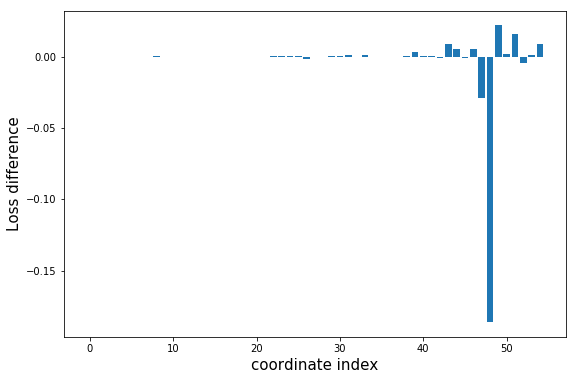

In [12]:
plt.bar(np.arange(len(step100_loss_diff)), step100_loss_diff, label='after step 100')
plt.xlabel('coordinate index', size=15)
plt.ylabel('Loss difference', size=15)

max_idx = np.argsort(step100_loss_diff)[::-1]
print('Reference loss: ', step100_hipr_losses[-1])
for idx in max_idx[:5]:
    print('coordinate: ', arcd.coords.internal.get_involved(idx, **ic_parms))
    print('with associated loss: ', step100_hipr_losses[idx])

In [13]:
trainhook.model.test_loss(trainhook.trainset)

1.3406338839383274

In [14]:
final_loss_diff[48]

-0.20001113388564562

In [15]:
arcd.coords.internal.get_involved(48, **ic_parms)

('cos', [6, 8, 14, 15])

(array([ 24.,  28.,  52.,  54.,  90., 189., 202., 170., 134.,  58.]),
 array([0.12758747, 0.21437331, 0.30115914, 0.38794498, 0.47473082,
        0.56151666, 0.6483025 , 0.73508833, 0.82187417, 0.90866001,
        0.99544585]),
 <a list of 10 Patch objects>)

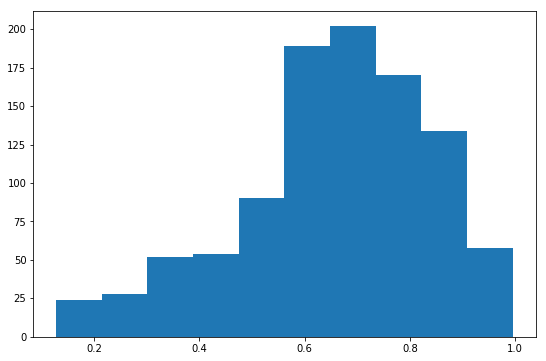

In [16]:
plt.hist(trainhook.trainset.descriptors[:, 48])

## Now we know that the dihedral between atoms 14, 16, 18 and 19 seems to be quite important....so what are these atoms?

In [23]:
# lets get a snapshot from trajectory, such that we can ask its topology object for the atom names
snap = storage.snapshots[-1]
topol = snap.topology.mdtraj

In [24]:
for at in [4, 6, 8, 14, 16, 18, 19]:
    print('atom: ', topol.atom(at), ' with index: ', at)

atom:  ACE1-C  with index:  4
atom:  ALA2-N  with index:  6
atom:  ALA2-CA  with index:  8
atom:  ALA2-C  with index:  14
atom:  NME3-N  with index:  16
atom:  NME3-C  with index:  18
atom:  NME3-H1  with index:  19


In [17]:
model_at_step100.test_loss(trainhook.trainset)

0.6966980620697661

In [18]:
trainhook.model.test_loss(trainhook.trainset)

1.3725112625411697

In [16]:
trainhook.trainset.descriptors.copy()

array([[1.09000117e-01, 1.54878810e-01, 1.08999938e-01, ...,
        4.91410494e-04, 2.35554904e-01, 7.56548643e-02],
       [1.08999930e-01, 1.52039677e-01, 1.08999878e-01, ...,
        5.24520874e-06, 8.12097907e-01, 8.90634000e-01],
       [1.09000124e-01, 1.49299413e-01, 1.09000020e-01, ...,
        1.92236602e-02, 6.53135598e-01, 2.40278542e-02],
       ...,
       [1.08999893e-01, 1.50930539e-01, 1.09000519e-01, ...,
        9.95385647e-03, 2.74688005e-04, 5.16571343e-01],
       [1.09000050e-01, 1.52551562e-01, 1.08999990e-01, ...,
        2.64850557e-02, 4.91738319e-04, 4.77830261e-01],
       [1.09000027e-01, 1.48676485e-01, 1.09000415e-01, ...,
        2.66651511e-02, 9.90160167e-01, 4.01293337e-01]])